# Read files

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os, h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from jason import jason_plotting as plotting
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/jasonwu/Programs/codes/def.mplstyle')
plotting.plot_prettier(dpi=400,usetex=False)
%matplotlib inline


Bad key grid.zorder in file /Users/jasonwu/Programs/codes/def.mplstyle, line 19 ('grid.zorder : 2.5')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# global variables
ECALZ_MIN = 247.9
ECALZ_MAX = 749.1
ECALW = 260

HCALZ_MIN = 879

# the style used for the confidence range plots
# 0: area
# 1: error bars
style = 1

# Loading the Particles

## Class

In [3]:
labels_keys = 'electrons neutrons photons pions protons electrons_hcal neutrons_hcal photons_hcal pions_hcal protons_hcal'.split(' ')
labels_values = [
    r'Electrons $e^{\minus}$',
    r'Neutrons $n^{o}$',
    r'Photons $\gamma$',
    r'Pions $\pi^{\minus}$',
    r'Protons $p^{\plus}$',
    r'Electrons $e^{\minus}$ HCal',
    r'Neutrons $n^{o}$ HCal',
    r'Photons $\gamma$ HCal',
    r'Pions $\pi^{\minus}$ HCal',
    r'Protons $p^{\plus}$ HCal'
]

labels_dict = {labels_keys[i]: labels_values[i] for i in range(len(labels_keys))}

In [4]:
# initiate a particle class
class Particles():
    def __init__(self, hf, zero_on='PFTruthTarget_energy'):
        # a list of properties
        self.propdict = {}
        # initiate all properties
        for prop in hf.keys():
            # convert to numpy array
            self.propdict[prop] = hf[prop][()]
        self._clean_props(zero_on)
    
    # clean the data set
    def _clean_props(self, zero_on='PFTruthTarget_energy'):
        # remove on column
        if isinstance(zero_on, list):
            # invalid energy values
            zero_bool_mask = np.array(self.propdict[zero_on[0]] <= 0)
            for zero_col in zero_on[1:]:
                zero_bool_mask = np.logical_and(zero_bool_mask, np.array(self.propdict[zero_col] <= 0))
        else:
            zero_bool_mask = np.array(self.propdict[zero_on] <= 0)
            
        print(f'{np.sum(zero_bool_mask)} values removed from {zero_on}')
        
        for prop in list(self.propdict.keys()):
            nan_bool_mask = np.isnan(self.propdict[prop])
            if np.any(nan_bool_mask):
                print(f'{np.sum(nan_bool_mask):<10} NaN values for {prop}')
                # set the values to zero
                self.propdict[prop][np.isnan(self.propdict[prop])] = 0
            self.propdict[prop] = self.propdict[prop][~zero_bool_mask]
                
        print('\n')
    
    # return a property
    def get(self, prop = None):
        if prop is not None:  # if specific property(ies) are given
            if isinstance(prop, list):
                prop_list = []
                for single_prop in prop:
                    prop_list.append(self.propdict[single_prop])
                return prop_list
            else:
                assert prop in list(self.propdict.keys())
                return self.propdict[prop]
        else:
            return self.propdict
    
    # account for mass of particle
    def acc_mass(self, mass, columns=[]):
        # subtract mass
        for column in columns:
            self.propdict[column] = np.clip(self.propdict[column] - mass, 0, None)
    
    # return a list of all properties
    def list_props(self):        
        print(f'{"Property Name":<30}{"Number of Entries":<20}{"Unique Entries":<20}{"Range":<30}{"Mean"}')
        
        for prop in list(self.propdict.keys()):
            print(f'{prop: <30}{len(self.propdict[prop]):<20}{len(np.unique(self.propdict[prop])):<8}\
            {np.min(self.propdict[prop]):<10.2f}{np.max(self.propdict[prop]):>8.2f}\
            {np.mean(self.propdict[prop]):<.2f}')
        print('\n')
        return list(self.propdict.keys())
    
    # apply a correction to the ecal and hcal energy measurements
    def o1corr_energy(self, verbose=True, scheme='nearest',  # three schemes 'none', 'nearest' and 'spline'
                      energy_bins_ecal=[0, 6e3], o1corr_ecal=[1],
                      energy_bins_hcal=[0, 6e3], o1corr_hcal=[1],
                      numbins=20, gev=True, label=labels_dict['photons']):
        # correct the energies
        match scheme:  # different schemes to handle values outside of measured bins
            case 'none':  # set to NaN, breaks plots
                # ecal
                o1corr_ecal = pd.cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal,
                                     include_lowest=True, labels=o1corr_ecal).to_numpy()
                # hcal
                o1corr_hcal = pd.cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal,
                                     include_lowest=True, labels=o1corr_hcal).to_numpy()
            case 'nearest':  # sets to value of nearest bin
                def nearest_cut(data, bins=[0, 6e3], labels=[1]):
                    # assigns labels to data based on bins
                    label_ind = np.digitize(data, bins=bins, right=True)
                    # contains 0 and len(labels)
                    label_ind[label_ind == 0] = 1  # label_ind will start at 1
                    label_ind[label_ind == len(bins)] = len(labels)  # set to maximum ind
                    return labels[label_ind - 1]
                # ecal
                o1corr_ecal = nearest_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = nearest_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
            case 'spline':
                def spline_cut(data, bins=[0, 6e3], labels=[1]):
                    # construct spline object for bin centers
                    bin_centers = [(a + b) / 2 for a, b in zip(bins[::], bins[1::])] # average of two consecutive elements in bins
                    # calculate splined values for data
                    splined_coeff, _ = plotting.spline_xy(bin_centers, labels, data)
                    return splined_coeff
                    
                # ecal
                o1corr_ecal = spline_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = spline_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
                
        energy_o1corr_ecal = self.get('PFCandidates_ecalEnergy') * o1corr_ecal
        energy_o1corr_hcal = self.get('PFCandidates_hcalEnergy') * o1corr_hcal
        
        
        # total
        energy_o1corr_total = energy_o1corr_ecal + energy_o1corr_hcal
        
        # set the dictionary entries
        self.propdict['PFCandidates_ecalEnergy_o1corr'] = energy_o1corr_ecal
        self.propdict['PFCandidates_hcalEnergy_o1corr'] = energy_o1corr_hcal
        self.propdict['PFCandidates_energy_o1corr'] = energy_o1corr_total
        
        # O(1) correction comparison plot with both energies
        if verbose:
            fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
            # set the truth energy depending on the type of particle simulation
            if (label is not None) and \
               ('HCal' in label):
                # if the particle went through both ecal and hcal
                print('HCal energy set to truth')
                energy_truth_total = self.get('PFTruthHcal_energy')  # the pre-hcal energy is set to truth
            else:
                print('Target energy set to truth')
                energy_truth_total = self.get('PFTruthTarget_energy')  # the pre-target energy is set to truth

            if gev:  # plot x axis in gev instead
                plt.xlim([0, 4])
                plt.xlabel('Truth Total Energy [GeV]')
                x = energy_truth_total/1e3
                textx = 3.5
            else:  # plot x axis in mev
                plt.xlim([0, 4000])
                plt.xlabel('Truth Total Energy [MeV]')
                x = energy_truth_total
                textx = 3500
            y1 = self.get('PFCandidates_energy')/energy_truth_total  # measured ratio
            y2 = energy_o1corr_total/energy_truth_total  # reconstructed ratio
            _ = plotting.percentile(x, y1, numbins=numbins, style=style,
                                    color='red', label='Measured', textpos=[textx, 1.5])
            _ = plotting.percentile(x, y2, numbins=numbins, style=style,
                                    color='blue', label='$\mathcal{O}(1)$ Reconstructed')
            plt.ylabel('Reconstructed / Truth Total Energy', fontsize=10)
            plt.legend(loc='upper right')
            plt.ylim([0, 2])
            plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=7, weight='bold')

        return energy_o1corr_ecal, energy_o1corr_hcal, energy_o1corr_total

## Dictionaries

In [5]:
# HCal particles
hcal_particles_dict = {
    'electrons_hcal': None,
    'photons_hcal': None,
    'neutrons_hcal': None,
    'pions_hcal': None,
    'protons_hcal': None
}

# ECal + HCal particles
both_particles_dict = {
    'electrons': None,
    'photons': None,
    'neutrons': None,
    'pions': None,
    'protons': None
}

In [6]:
import pickle

# dump the particles into pickle files
for file_name in hcal_particles_dict.keys():
    with open(f"data/pickles/{file_name}.pkl", 'rb') as handle:
        data = handle.read()
    hcal_particles_dict[file_name] = pickle.loads(data)

for file_name in both_particles_dict.keys():
    with open(f"data/pickles/{file_name}.pkl", 'rb') as handle:
        data = handle.read()
    both_particles_dict[file_name] = pickle.loads(data)

In [7]:
electrons_hcal = hcal_particles_dict['electrons_hcal']
photons_hcal = hcal_particles_dict['photons_hcal']
neutrons_hcal = hcal_particles_dict['neutrons_hcal']
pions_hcal = hcal_particles_dict['pions_hcal']
protons_hcal = hcal_particles_dict['protons_hcal']

electrons = both_particles_dict['electrons']
photons = both_particles_dict['photons']
neutrons = both_particles_dict['neutrons']
pions = both_particles_dict['pions']
protons = both_particles_dict['protons']

In [8]:
_ = electrons_hcal.list_props()

Property Name                 Number of Entries   Unique Entries      Range                         Mean
PFCandidates_ecalClusterDXDZ  10000               4                   -0.12         0.04            -0.00
PFCandidates_ecalClusterDYDZ  10000               4                   0.00          0.05            0.00
PFCandidates_ecalClusterEDXDZ 10000               4                   0.00          0.00            0.00
PFCandidates_ecalClusterEDYDZ 10000               4                   0.00          0.00            0.00
PFCandidates_ecalClusterEX    10000               39                  0.00        156.32            0.18
PFCandidates_ecalClusterEY    10000               36                  0.00        181.89            0.16
PFCandidates_ecalClusterEZ    10000               17                  0.00        247.29            0.15
PFCandidates_ecalClusterX     10000               231                 -253.37     255.78            0.51
PFCandidates_ecalClusterY     10000               162 

# Simple Criteria Classification

## Comparisons of properties

In [9]:
_ = electrons.list_props()

Property Name                 Number of Entries   Unique Entries      Range                         Mean
PFCandidates_ecalClusterDXDZ  9965                9955                -0.85         0.38            -0.04
PFCandidates_ecalClusterDYDZ  9965                9955                -0.54         0.46            -0.00
PFCandidates_ecalClusterEDXDZ 9965                9954                0.00          0.22            0.00
PFCandidates_ecalClusterEDYDZ 9965                9952                0.00          0.06            0.00
PFCandidates_ecalClusterEX    9965                9950                0.00        168.36            21.64
PFCandidates_ecalClusterEY    9965                9929                0.00         94.41            20.42
PFCandidates_ecalClusterEZ    9965                9793                0.00        137.00            52.16
PFCandidates_ecalClusterX     9965                9937                -236.51     142.07            -13.59
PFCandidates_ecalClusterY     9965              

### Properties to compare

A classification algorithm based on limit cuts. The following attributes are considered:

* `PFCandidates_ecalClusterZ`

    * How far back in the ECal detector
    
* `PFCandidates_hcalClusterZ`
    
    * How far back in the HCal detector

* `PFCandidates_ecalClusterEX` and `PFCandidates_ecalClusterEY`

* `PFCandidates_hcalClusterEX` and `PFCandidates_hcalClusterEY`
    
* `PFCandidates_ecalEnergy_o1corr` and `PFCandidates_hcalEnergy_o1corr`

    * Individual
    * Proportions

### Particles to compare

Non-charged particles (don't leave tracks)
* photons
* neutrons

Charged particles (do leave tracks)
* electrons
* pions
* protons

Particles only need to be distinguished within their category

In [10]:
def plot_prop_comparison(prop, particles=[], labels=['', ''], nbins=50, binwidth=10):
    import seaborn as sns
    # get properties for each particle
    props = [part.get(prop) for part in particles]

    fig, ax = plt.subplots(figsize=(5, 2), dpi=200)
    plotting.hist(fig, ax, props, labels, nbins=nbins, binwidth=binwidth,
                  draw_quartiles=True, xlabel=prop, ylabel='Density')
    plt.legend(loc='best')

def simple_prop_comparison(prop, particle_names, nbins=50, binwidth=10):
    particles = [both_particles_dict[particle_name] for particle_name in particle_names]
    labels = [labels_dict[particle_name] for particle_name in particle_names]
    plot_prop_comparison(prop, particles, labels, nbins=nbins, binwidth=binwidth)

#### Charged Particles

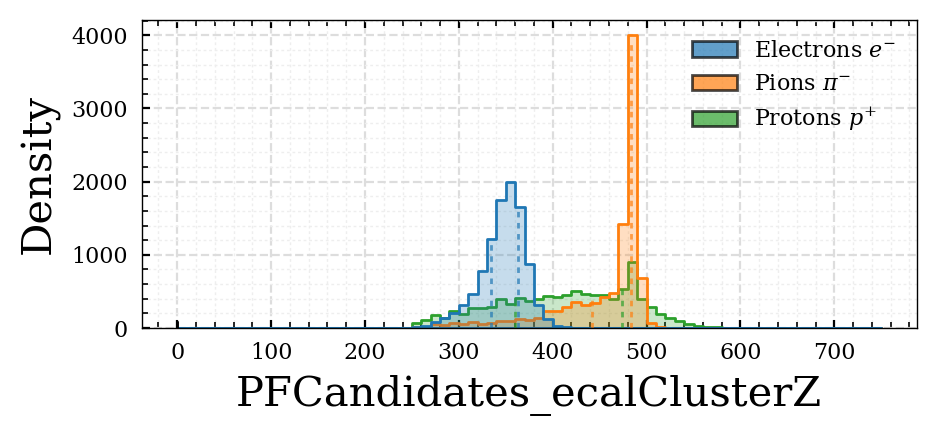

In [11]:
# PFCandidates_ecalClusterZ < 400 electrons
# PFCandidates_ecalClusterZ > 400 pions
simple_prop_comparison('PFCandidates_ecalClusterZ', ['electrons', 'pions', 'protons'])
plt.show()

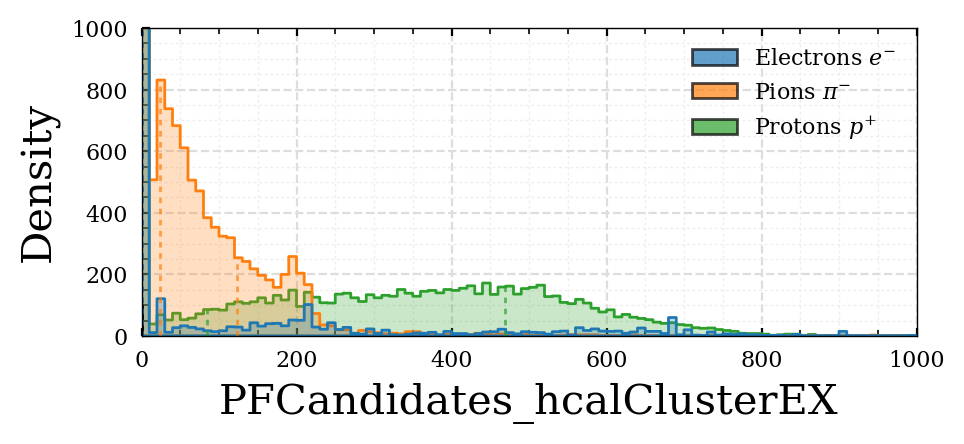

In [12]:
# PFCandidates_hcalClusterEX > 100 protons
# PFCandidates_hcalClusterEX < 100 pions
simple_prop_comparison('PFCandidates_hcalClusterEX', ['electrons', 'pions', 'protons'], binwidth=10)
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.show()

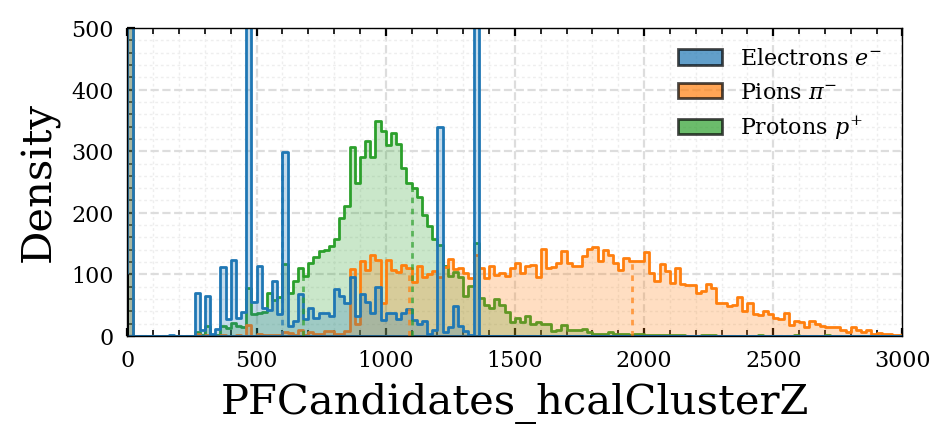

In [13]:
# PFCandidates_hcalClusterZ == 0 electrons, remove
# PFCandidates_hcalClusterZ > 1400 pions
# PFCandidates_hcalClusterZ < 1400 protons
simple_prop_comparison('PFCandidates_hcalClusterZ', ['electrons', 'pions', 'protons'], binwidth=20)
plt.xlim(0, 3000)
plt.ylim(0, 500)
plt.show()

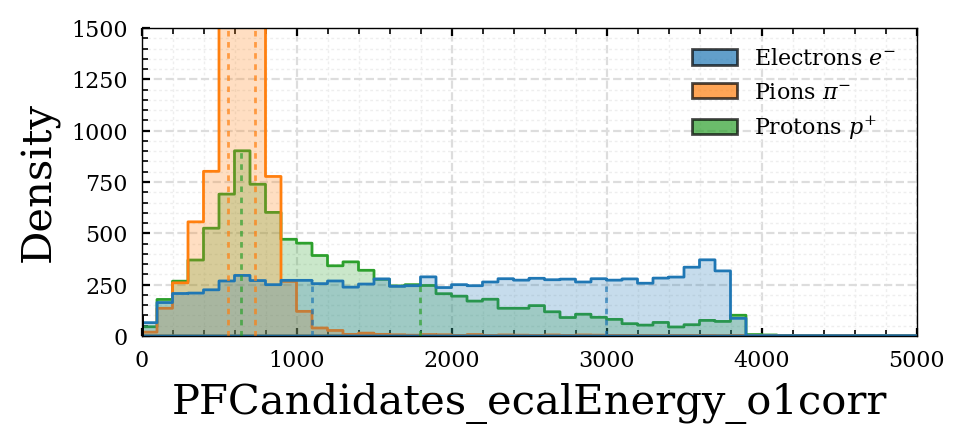

In [14]:
# PFCandidates_ecalEnergy_o1corr > 1000 protons
simple_prop_comparison('PFCandidates_ecalEnergy_o1corr', ['electrons', 'pions', 'protons'], binwidth=100)
plt.xlim(0, 5e3)
plt.ylim(0, 1500)
plt.show()

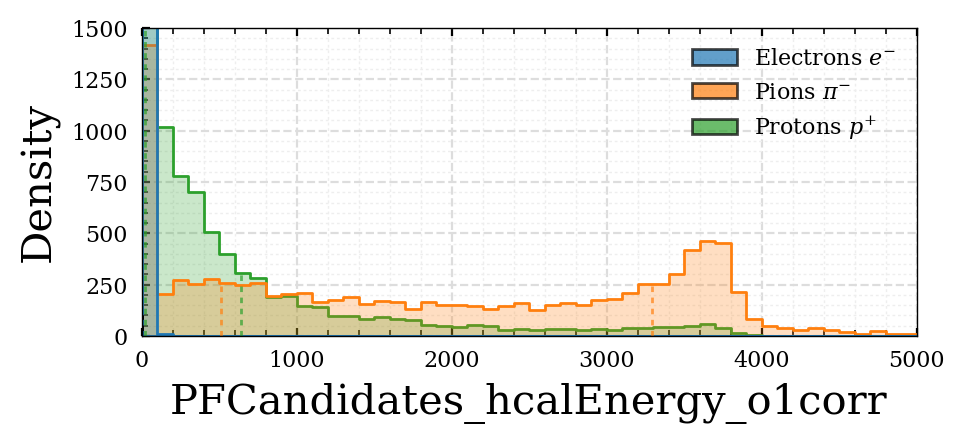

In [15]:
# PFCandidates_hcalEnergy_o1corr > 750 pions
simple_prop_comparison('PFCandidates_hcalEnergy_o1corr', ['electrons', 'pions', 'protons'], binwidth=100)
plt.xlim(0, 5e3)
plt.ylim(0, 1500)
plt.show()

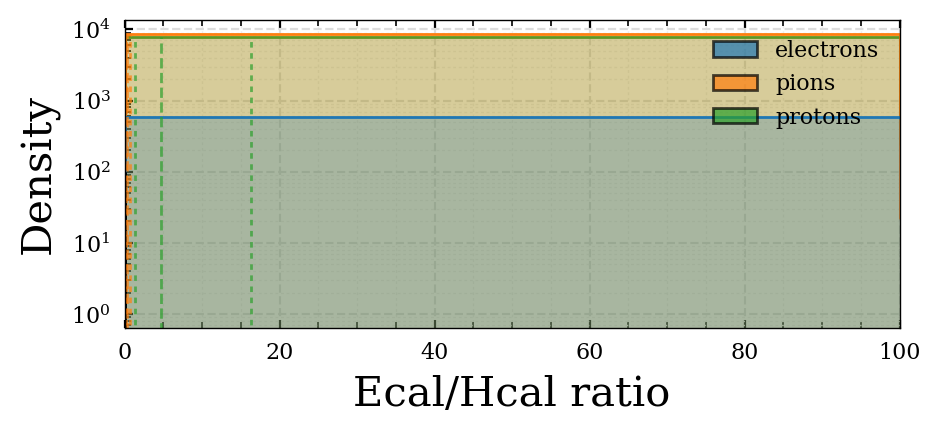

In [16]:
# ratio > 100 electrons, remove
fig, ax = plt.subplots(figsize=(5, 2), dpi=200)
data = plotting._clean_data_ind(electrons.get('PFCandidates_ecalEnergy_o1corr')/electrons.get('PFCandidates_hcalEnergy_o1corr'),
                                pions.get('PFCandidates_ecalEnergy_o1corr')/pions.get('PFCandidates_hcalEnergy_o1corr'),
                                protons.get('PFCandidates_ecalEnergy_o1corr')/protons.get('PFCandidates_hcalEnergy_o1corr'))
plotting.hist(fig, ax, data, ['electrons', 'pions', 'protons'], binwidth=100,
              draw_median=True, draw_quartiles=True, xlabel='Ecal/Hcal ratio', ylabel='Density')
ax.set_yscale('log')
plt.xlim(0, 100)
plt.legend(loc='best')
plt.show()

#### Neutral Particles

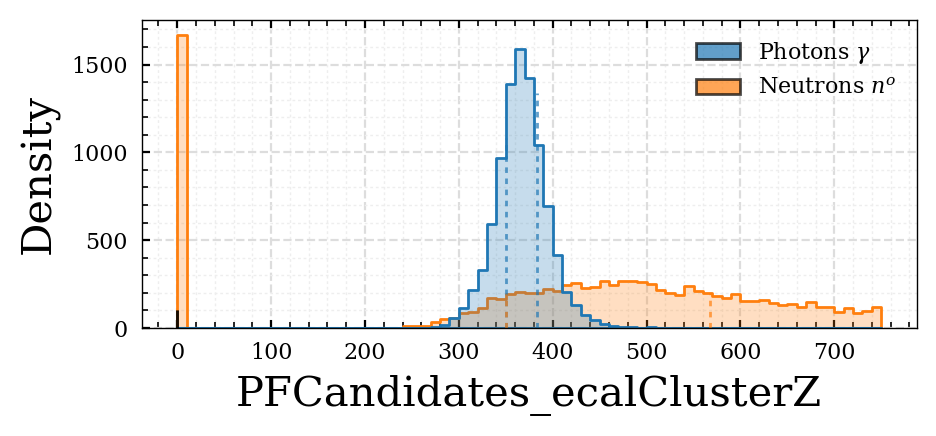

In [17]:
simple_prop_comparison('PFCandidates_ecalClusterZ', ['photons', 'neutrons'])
plt.show()

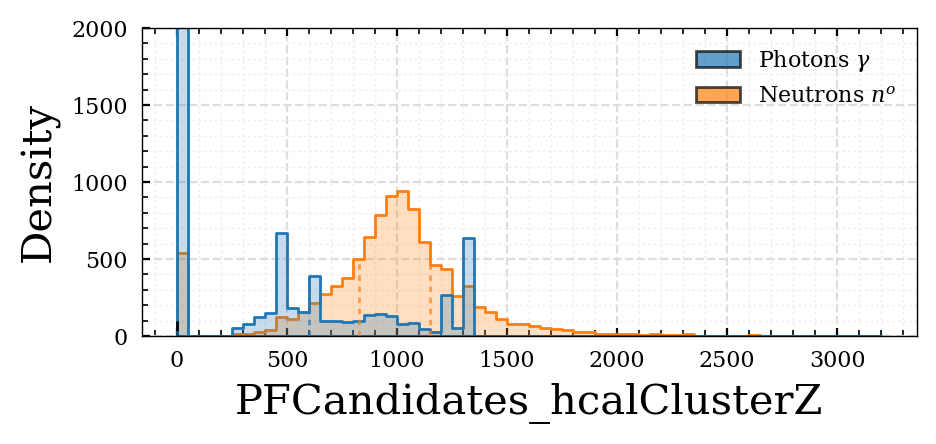

In [18]:
simple_prop_comparison('PFCandidates_hcalClusterZ', ['photons', 'neutrons'], binwidth=50)
plt.ylim(0, 2000)
plt.show()

##### Mini-investigation

In [19]:
np.nanmean(protons.get('PFCandidates_trackPx')/protons.get('PFCandidates_trackPz'))

0.03119257

In [20]:
np.nanmean(photons.get('PFCandidates_trackPx')/photons.get('PFCandidates_trackPz'))

-0.00022951065

What are the deflection angles of neutrons with `PFCandidates_hcalClusterZ` or `PFCandidates_ecalEnergy_o1corr` = 0

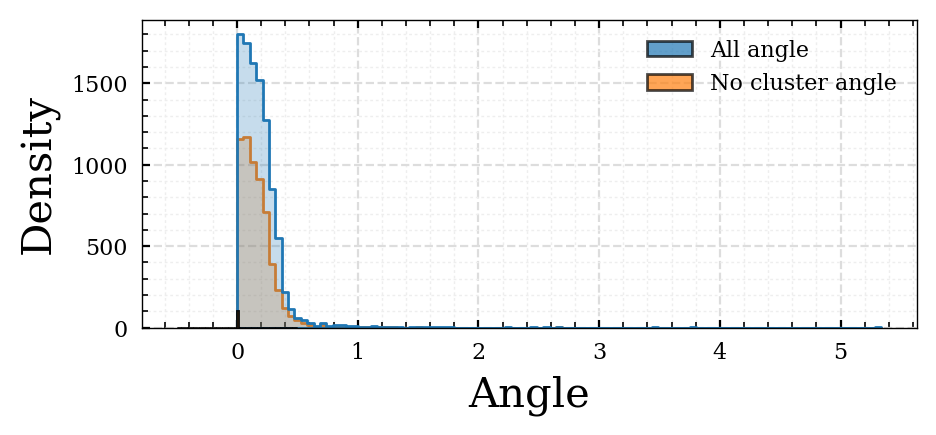

In [21]:
mask = electrons.get('PFCandidates_hcalClusterZ') == 0
unmasked = np.abs(electrons.get('PFCandidates_trackPx')/electrons.get('PFCandidates_trackPz'))
masked = unmasked[mask]

fig, ax = plt.subplots(figsize=(5, 2), dpi=200)
plotting.hist(fig, ax, [unmasked, masked], ['All angle', 'No cluster angle'], nbins=100,
              xlabel='Angle', ylabel='Density')
plt.legend(loc='best')
plt.show()

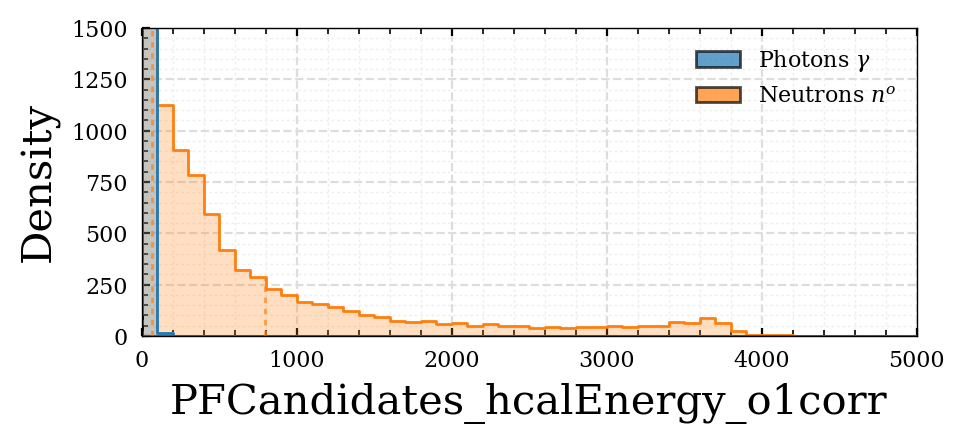

In [32]:
simple_prop_comparison('PFCandidates_hcalEnergy_o1corr', ['photons', 'neutrons'], binwidth=100)
plt.xlim(0, 5e3)
plt.ylim(0, 1500)
plt.show()

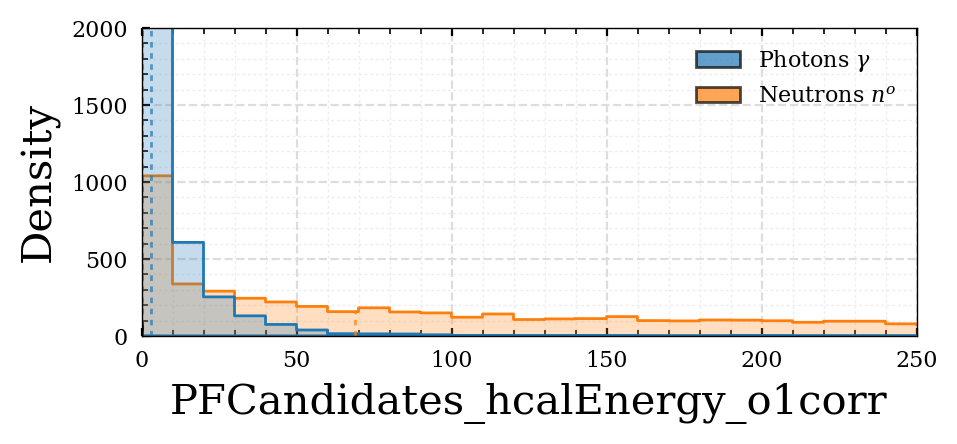

In [23]:
simple_prop_comparison('PFCandidates_hcalEnergy_o1corr', ['photons', 'neutrons'], binwidth=10)
plt.xlim(0, 250)
plt.ylim(0, 2000)
plt.show()

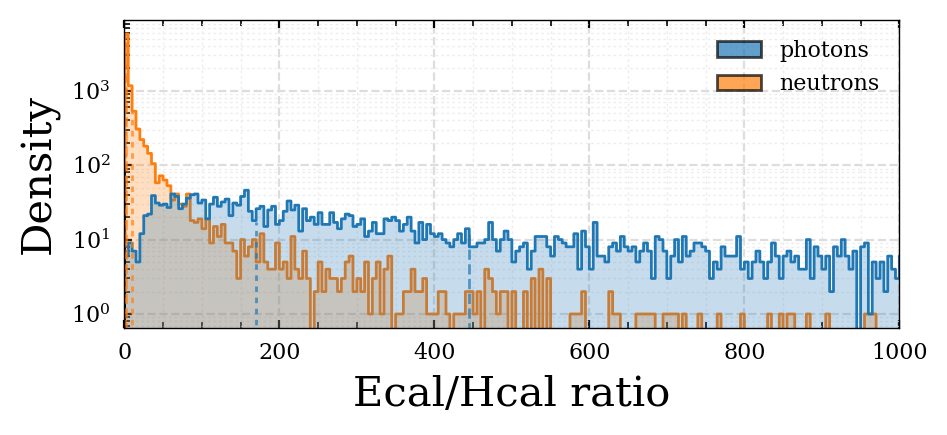

In [24]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=200)
data = plotting._clean_data_ind(photons.get('PFCandidates_ecalEnergy_o1corr')/photons.get('PFCandidates_hcalEnergy_o1corr'),
                                neutrons.get('PFCandidates_ecalEnergy_o1corr')/neutrons.get('PFCandidates_hcalEnergy_o1corr'))
plotting.hist(fig, ax, data, ['photons', 'neutrons'], binwidth=5,
              draw_median=True, draw_quartiles=True, xlabel='Ecal/Hcal ratio', ylabel='Density')
ax.set_yscale('log')
plt.xlim(0, 1000)
plt.legend(loc='best')
plt.show()

## Finding optimal separation

### Functions

In [25]:
# the list of properties to include in the df
prop_list = [
    'PFCandidates_ecalClusterZ',
    'PFCandidates_hcalClusterZ',
    'PFCandidates_ecalEnergy_o1corr',
    'PFCandidates_hcalEnergy_o1corr',
    'ratio',
    'PFCandidates_ecalClusterEX',
    'PFCandidates_ecalClusterEY',
    'PFCandidates_hcalClusterEX',
    'PFCandidates_hcalClusterEY',
]

def stack_samples(particles_names, prop_list=prop_list):
    df_list = []
    for particle_name in particles_names:
        # retrieve the particle
        particle = both_particles_dict[particle_name]

        # make dataframe with particle labels
        particle_df = {}
        for prop in prop_list:
            if prop == 'ratio':
                particle_df[prop] = particle.get('PFCandidates_ecalEnergy_o1corr')/particle.get('PFCandidates_hcalEnergy_o1corr')
            else:
                particle_df[prop] = particle.get(prop)
        particle_df['true_label'] = particle_name
        particle_df = pd.DataFrame(particle_df)
        df_list.append(particle_df)
    full_df = pd.concat(df_list, ignore_index=True, axis=0)
    
    for particle_name in particles_names:
        full_df[particle_name+'_votes'] = 0  # initialize zero columns

    full_df['predicted_label'] = 'unknown'
    return full_df

def criteria(df, col, ufunc, label, remove=False, points=1):
    umask = ufunc(df[col])  # columns that satisfy this condition
    if remove:  # directly set the end product to label
        df['predicted_label'].mask(cond=umask, other=label, inplace=True)
    else:  # add one to the label
        df[label+'_votes'][umask] += points
    return df

def determine(df, particles_names, fill_unknown=False):
    particles_votes = [df[particle_name+'_votes'] for particle_name in particles_names]
    # the indices of each row corresponding to particle labels
    dertermined_ind = np.sum(particles_votes, axis=0).astype(bool)  # 0 means the particle is undetermined

    # most votes
    max_vote_ind = np.array([np.random.choice(np.flatnonzero(np.isclose(b, b.max()))) for b in np.array(particles_votes).T])
    # max_vote_ind = np.argmax(particles_votes, axis=0)  # the most votes
    

    for index, row in df.iterrows():
        if row['predicted_label'] == 'unknown':  # if no particles are assigned already
            if dertermined_ind[index]:
                df.at[index, 'predicted_label'] = particles_names[max_vote_ind[index]]
            else:  # no determination whatsoever
                if fill_unknown:
                    # fill the undetermined spot with random
                    df.at[index, 'predicted_label'] = np.random.choice(particles_names)
    return df

In [26]:
# list all the particles
list(both_particles_dict.keys())

['electrons', 'photons', 'neutrons', 'pions', 'protons']

## Analyzing particles

### Charged

* `PFCandidates_hcalClusterZ` == 0 electrons, remove
* `PFCandidates_ecalEnergy_o1corr` / `PFCandidates_hcalEnergy_o1corr` > 100 electrons, remove

---

* `PFCandidates_hcalClusterEX` > 100 protons
* `PFCandidates_hcalClusterEX` < 100 pions
* `PFCandidates_ecalClusterZ` < 400 electrons
* `PFCandidates_ecalClusterZ` > 400 pions
* `PFCandidates_hcalClusterZ` > 1400 pions
* `PFCandidates_hcalClusterZ` < 1400 protons
* `PFCandidates_ecalEnergy_o1corr` > 1000 protons
* `PFCandidates_hcalEnergy_o1corr` > 750 pions

In [38]:
charged_df = stack_samples(['electrons', 'pions', 'protons'])

# removal criteria
charged_df = criteria(charged_df, 'PFCandidates_hcalClusterZ', lambda x:x==0, 'electrons', remove=True)
charged_df = criteria(charged_df, 'ratio', lambda x:x>100, 'electrons', remove=True)
# non-removal criteria
charged_df = criteria(charged_df, 'PFCandidates_hcalClusterEX', lambda x:x>200, 'protons')
charged_df = criteria(charged_df, 'PFCandidates_hcalClusterEX', lambda x:x<150, 'pions')
charged_df = criteria(charged_df, 'PFCandidates_ecalClusterZ', lambda x:x<400, 'electrons')
charged_df = criteria(charged_df, 'PFCandidates_ecalClusterZ', lambda x:x>400, 'pions')  # weak
charged_df = criteria(charged_df, 'PFCandidates_hcalClusterZ', lambda x:x>1400, 'pions')
charged_df = criteria(charged_df, 'PFCandidates_hcalClusterZ', lambda x:x<1400, 'protons')
charged_df = criteria(charged_df, 'PFCandidates_ecalEnergy_o1corr', lambda x:x>1000, 'protons', points=2)  # strong
charged_df = criteria(charged_df, 'PFCandidates_hcalEnergy_o1corr', lambda x:x>750, 'pions')

# tally the votes
charged_df = determine(charged_df, ['electrons', 'pions', 'protons'])
display(charged_df)
np.unique(charged_df['true_label'], return_counts=True), np.unique(charged_df['predicted_label'], return_counts=True)

,PFCandidates_ecalClusterZ,PFCandidates_hcalClusterZ,PFCandidates_ecalEnergy_o1corr,PFCandidates_hcalEnergy_o1corr,ratio,PFCandidates_ecalClusterEX,PFCandidates_ecalClusterEY,PFCandidates_hcalClusterEX,PFCandidates_hcalClusterEY,true_label,electrons_votes,pions_votes,protons_votes,predicted_label
0,380.557434,0.000000,2524.664734,0.000000,inf,19.447166,23.509224,0.000000,0.000000,electrons,1,1,3,electrons
1,356.954712,1246.666626,2734.130977,9.188971,297.544835,35.767288,26.395596,647.870422,581.713196,electrons,1,0,4,electrons
2,343.128296,0.000000,1345.551255,0.000000,inf,17.148550,24.999971,0.000000,0.000000,electrons,1,1,3,electrons
3,350.491791,1200.000000,2055.902858,9.989014,205.816405,21.003035,26.574516,0.000000,0.000000,electrons,1,1,3,electrons
4,317.571289,0.000000,1150.326512,0.000000,inf,21.594044,18.236805,0.000000,0.000000,electrons,1,1,3,electrons
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29735,326.289246,799.777771,542.250630,36.865396,14.708933,23.953619,9.380369,327.570709,289.337585,protons,1,0,2,protons
29736,465.593201,1248.145874,673.330383,2363.498570,0.284887,15.558496,47.924603,276.933990,386.821533,protons,0,2,2,protons
29737,463.884674,0.000000,1198.106233,0.000000,inf,6.608784,40.461369,0.000000,0.000000,protons,0,2,3,electrons
29738,358.875336,0.000000,781.190224,0.000000,inf,26.029778,15.766601,0.000000,0.000000,protons,1,1,1,electrons


((array(['electrons', 'pions', 'protons'], dtype=object),
  array([9965, 9873, 9902])),
 (array(['electrons', 'pions', 'protons'], dtype=object),
  array([13089,  9644,  7007])))

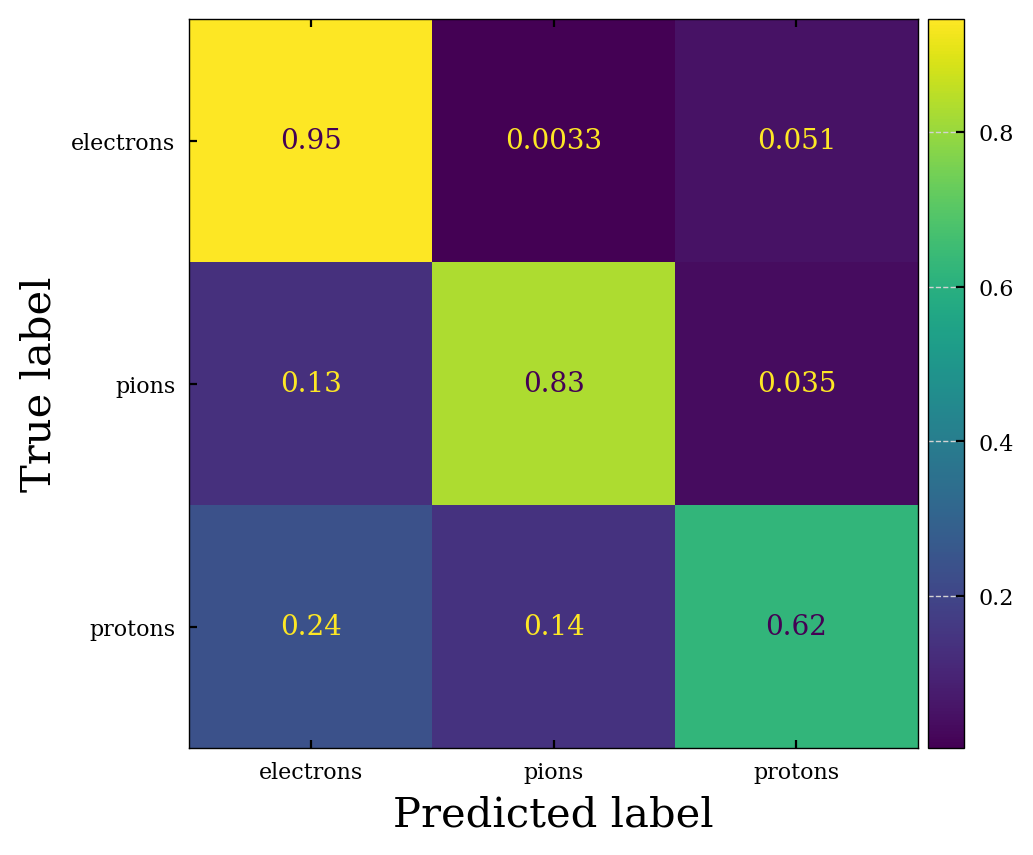

In [39]:
def plot_confusion_matrix(fig, ax, actual, predicted, labels, cmap='viridis'):
    from sklearn import metrics
    confusion_matrix = metrics.confusion_matrix(actual, predicted, normalize='true')

    if (fig is None) or (ax is None):
        fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    ax.grid(False)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
    cm_display.plot(ax=ax, colorbar=False, cmap=cmap, xticks_rotation='horizontal')
    plotting.colorbar(cm_display.im_)
    plt.show()
    
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
actual = charged_df['true_label']
predicted = charged_df['predicted_label']
plot_confusion_matrix(fig, ax, actual, predicted, labels=np.unique(charged_df['true_label']))

### Neutral

* If `PFCandidates_ecalClusterZ` = 0 neutrons, remove
* If `PFCandidates_hcalClusterZ` = 0 photons, remove

---

* If `PFCandidates_ecalClusterZ` < 400 photons
* If `PFCandidates_ecalClusterZ` > 400 neutrons
* If `PFCandidates_ecalEnergy_o1corr` > 500 photons
* If `PFCandidates_ecalEnergy_o1corr` < 500 neutrons
* If `PFCandidates_hcalEnergy_o1corr` < 75 photons
* If `PFCandidates_hcalEnergy_o1corr` > 75 neutrons
* If `PFCandidates_ecalEnergy_o1corr` / `PFCandidates_hcalEnergy_o1corr` > 100 photon
* If `PFCandidates_ecalEnergy_o1corr` / `PFCandidates_hcalEnergy_o1corr` < 100 neutrons

In [29]:
neutral_df = stack_samples(['photons', 'neutrons'])

# removal criteria
neutral_df = criteria(neutral_df, 'PFCandidates_hcalClusterZ', lambda x:x>1500, 'neutrons', remove=True)
neutral_df = criteria(neutral_df, 'PFCandidates_ecalClusterZ', lambda x:x==0, 'neutrons', remove=True)  # override
# non-removal criteria
neutral_df = criteria(neutral_df, 'PFCandidates_ecalClusterZ', lambda x:x<430, 'photons')
neutral_df = criteria(neutral_df, 'PFCandidates_ecalClusterZ', lambda x:x>350, 'neutrons')
neutral_df = criteria(neutral_df, 'PFCandidates_ecalEnergy_o1corr', lambda x:x>1000, 'photons')
neutral_df = criteria(neutral_df, 'PFCandidates_ecalEnergy_o1corr', lambda x:x<1500, 'neutrons')
neutral_df = criteria(neutral_df, 'PFCandidates_hcalEnergy_o1corr', lambda x:x<30, 'photons')
neutral_df = criteria(neutral_df, 'PFCandidates_hcalEnergy_o1corr', lambda x:x>30, 'neutrons')
neutral_df = criteria(neutral_df, 'ratio', lambda x:x>100, 'photons')
neutral_df = criteria(neutral_df, 'ratio', lambda x:x<100, 'neutrons')

# tally the votes
neutral_df = determine(neutral_df, ['photons', 'neutrons'], fill_unknown=False)
display(neutral_df)
np.unique(neutral_df['true_label'], return_counts=True), np.unique(neutral_df['predicted_label'], return_counts=True)

,PFCandidates_ecalClusterZ,PFCandidates_hcalClusterZ,PFCandidates_ecalEnergy_o1corr,PFCandidates_hcalEnergy_o1corr,ratio,PFCandidates_ecalClusterEX,PFCandidates_ecalClusterEY,PFCandidates_hcalClusterEX,PFCandidates_hcalClusterEY,true_label,photons_votes,neutrons_votes,predicted_label
0,362.785706,0.000000,848.208602,0.000000,inf,13.698007,32.540268,0.000000,0.000000,photons,3,2,photons
1,375.187469,1340.000000,3378.214014,12.383389,272.802049,18.504915,18.712149,0.000000,0.000000,photons,4,1,photons
2,386.349487,0.000000,2189.673257,0.000000,inf,19.710646,23.173744,0.000000,0.000000,photons,4,1,photons
3,348.455963,0.000000,293.194716,0.000000,inf,18.533016,5.898205,0.000000,0.000000,photons,3,1,photons
4,328.121307,928.000000,985.172888,1.394161,706.642226,23.111883,10.870675,0.000000,0.000000,photons,3,1,photons
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19254,571.368774,895.200012,3672.111203,417.669043,8.791916,29.954374,73.329880,209.794357,376.826263,neutrons,1,3,neutrons
19255,735.505981,1049.321411,73.381556,2357.432176,0.031128,0.000000,0.000000,238.299377,154.514786,neutrons,0,4,neutrons
19256,567.693298,890.736816,2529.962579,476.690076,5.307353,30.732052,29.336926,253.803497,289.960297,neutrons,1,3,neutrons
19257,392.806183,958.125000,3617.926876,35.864907,100.876518,43.306965,36.637188,668.882019,532.224670,neutrons,3,2,photons


((array(['neutrons', 'photons'], dtype=object), array([9881, 9378])),
 (array(['neutrons', 'photons'], dtype=object), array([9298, 9961])))

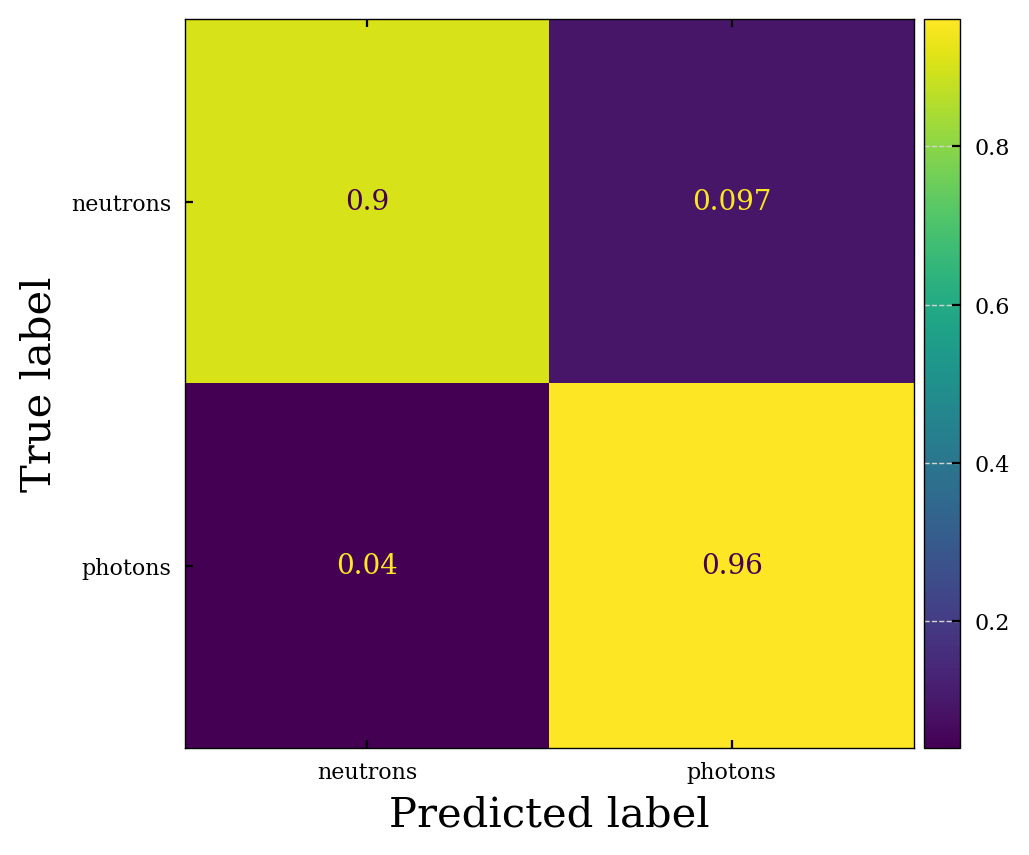

In [30]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
actual = neutral_df['true_label']
predicted = neutral_df['predicted_label']
plot_confusion_matrix(fig, ax, actual, predicted, labels=np.unique(neutral_df['true_label']))